In [3]:
!pip install yfinance pandas numpy matplotlib nltk praw

In [4]:
import pandas as pd
import numpy as np
import yfinance as yf
import praw
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.colors as mcolors
import time
import datetime
import pytz
from IPython.display import clear_output
from sklearn.linear_model import LinearRegression


FEATURES = ['Compound', 'Positive', 'Negative', 'Neutral', 'Post_Count', 'Close', 'Volume', 'Returns']
TARGET = 'Target'


nltk.download('vader_lexicon')


sid = SentimentIntensityAnalyzer()



[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [5]:

reddit = praw.Reddit(client_id='VRtxiNolzQ44cDJAXdLH7g',
                     client_secret='YCwtJ0jfXLAgSrBNkutPcp3HwlKuBg',
                     user_agent='Owais Raza', check_for_async=False)

In [6]:

def fetch_data(ticker, period="1d", interval="1m"):
    """Fetch real-time stock data and reddit posts"""
    # Fetch latest stock data
    price_data = yf.download(ticker, period=period, interval=interval, progress=False)
    price_data = price_data.reset_index()[['Datetime', 'Close', 'Volume']]
    price_data.columns = ['Date', 'Close', 'Volume']

    # Convert from market timezone to IST timezone
    price_data['Date'] = pd.to_datetime(price_data['Date']).dt.tz_convert('Asia/Kolkata')

    # Fetch latest reddit posts
    posts = reddit.subreddit('stocks+investing+wallstreetbets').new(limit=100)

    # Get current price
    current_price = price_data['Close'].iloc[-1] if not price_data.empty else None

    return price_data, posts, current_price


In [7]:


def analyze_sentiment(posts, ticker):
    """Analyze sentiment from reddit posts, filtering for the ticker"""
    sentiment_data = []
    ticker = ticker.lower()

    for post in posts:
        try:

            title = post.title.lower()
            text = post.selftext.lower()
            combined_text = title + ' ' + text


            if ticker in combined_text:
                # Convert UTC to IST
                date = pd.to_datetime(post.created_utc, unit='s', utc=True).tz_convert('Asia/Kolkata').floor('min')
                scores = sid.polarity_scores(title + ' ' + text)
                sentiment_data.append({
                    'Date': date,
                    'Compound': scores['compound'],
                    'Positive': scores['pos'],
                    'Negative': scores['neg'],
                    'Neutral': scores['neu'],
                    'Post_Count': 1
                })
        except Exception as e:
            print(f"Error processing post: {e}")
            continue

    if sentiment_data:
        sentiment_df = pd.DataFrame(sentiment_data)

        # Use IST timezone
        now = pd.Timestamp.now(tz='Asia/Kolkata').floor('min')
        date_range = pd.date_range(end=now, periods=60, freq='min', tz='Asia/Kolkata')
        template = pd.DataFrame({'Date': date_range})


        sentiment_df = sentiment_df.groupby('Date').agg({
            'Compound': 'mean', 'Positive': 'mean', 'Negative': 'mean',
            'Neutral': 'mean', 'Post_Count': 'sum'
        }).reset_index()


        sentiment_df = template.merge(sentiment_df, on='Date', how='left')
        return sentiment_df
    else:
        # Use IST timezone
        now = pd.Timestamp.now(tz='Asia/Kolkata').floor('min')
        date_range = pd.date_range(end=now, periods=60, freq='min', tz='Asia/Kolkata')
        return pd.DataFrame({
            'Date': date_range,
            'Compound': [0] * len(date_range),
            'Positive': [0] * len(date_range),
            'Negative': [0] * len(date_range),
            'Neutral': [0] * len(date_range),
            'Post_Count': [0] * len(date_range)
        })



In [8]:


def process_data(price_data, daily_sentiment):
    """Process and merge price and sentiment data"""
    data = price_data.merge(
        daily_sentiment, on='Date', how='left'
    ).assign(
        **{col: lambda x: x[col].fillna(0) for col in ['Compound', 'Positive', 'Negative', 'Neutral']},
        Post_Count = lambda x: x['Post_Count'].fillna(0),
        Returns = lambda x: x['Close'].pct_change(),
        Target = lambda x: (x['Close'].shift(-1) > x['Close']).astype(int)
    )
    return data.dropna()

In [9]:

def train_model(data):
    """Train a random forest model on the data"""

    if len(data) < 10:

        model = RandomForestClassifier(n_estimators=100, random_state=42)
        model.fit(np.zeros((5, len(FEATURES))), np.zeros(5))

        data['Pred_Proba'] = 0.5
        data['Prediction'] = 0
        return data, model

    X_train, X_test, y_train, y_test = train_test_split(
        data[FEATURES], data[TARGET], test_size=0.2, shuffle=False
    )
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)


    probas = model.predict_proba(data[FEATURES])
    data['Pred_Proba'] = probas[:, 1]
    data['Prediction'] = model.predict(data[FEATURES])

    return data, model


In [10]:

def generate_signals(data):
    """Generate trading signals based on sentiment, price, and ML predictions"""

    data['Sentiment_MA'] = data['Compound'].rolling(3).mean().fillna(0)


    data['Price_MA_Fast'] = data['Close'].rolling(5).mean().fillna(data['Close'])
    data['Price_MA_Slow'] = data['Close'].rolling(15).mean().fillna(data['Close'])


    data['Sentiment_Signal'] = np.select([
        data['Compound'] > data['Sentiment_MA'] + 0.05,
        data['Compound'] < data['Sentiment_MA'] - 0.05
    ], [1, -1], default=0)

    data['Price_Signal'] = np.select([
        data['Price_MA_Fast'] > data['Price_MA_Slow'],
        data['Price_MA_Fast'] < data['Price_MA_Slow']
    ], [1, -1], default=0)


    data['Combined_Signal'] = np.where(
        data['Prediction'] == 1,
        np.maximum(data['Sentiment_Signal'] + data['Price_Signal'], -1),
        np.minimum(data['Sentiment_Signal'] + data['Price_Signal'], 1)
    )


    data['Final_Signal'] = np.select([
        (data['Combined_Signal'] >= 1) | (data['Pred_Proba'] > 0.65),
        (data['Combined_Signal'] <= -1) | (data['Pred_Proba'] < 0.35)
    ], [1, -1], default=0)


    data['Strategy_Returns'] = data['Final_Signal'].shift(1) * data['Returns'] * 0.5

    return data


In [11]:


def visualize_strategy(data, ticker, current_price):
    """Create visualizations for the strategy"""

    sharpe_ratio = (data['Strategy_Returns'].mean() / data['Strategy_Returns'].std() * np.sqrt(252)
                    if data['Strategy_Returns'].std() != 0 else 0)


    buy_signals = data['Final_Signal'].value_counts().get(1, 0)
    sell_signals = data['Final_Signal'].value_counts().get(-1, 0)

    # Display current price and IST time
    ist_time = datetime.datetime.now(pytz.timezone('Asia/Kolkata')).strftime('%Y-%m-%d %H:%M:%S')
    print(f"Analysis for {ticker} - Last updated: {ist_time} (IST)")
    print(f"Current Price: {current_price:.2f}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Buy Signals: {buy_signals}, Sell Signals: {sell_signals}")
    print(f"Total Signals: {buy_signals + sell_signals} out of {len(data)} data points")


    fig, axs = plt.subplots(3, 1, figsize=(14, 12), gridspec_kw={'height_ratios': [3, 2, 1]})


    axs[0].plot(data['Date'], data['Close'], label='Price', color='black')
    axs[0].plot(data[data['Final_Signal'] == 1]['Date'],
             data['Close'][data['Final_Signal'] == 1], '^', markersize=10, color='g', label='Buy')
    axs[0].plot(data[data['Final_Signal'] == -1]['Date'],
             data['Close'][data['Final_Signal'] == -1], 'v', markersize=10, color='r', label='Sell')


    axs[0].plot(data['Date'], data['Price_MA_Fast'], '--', color='blue', alpha=0.7, label='Fast MA')
    axs[0].plot(data['Date'], data['Price_MA_Slow'], '--', color='orange', alpha=0.7, label='Slow MA')

    axs[0].set_title(f"{ticker} Trading Signals - Current Price: ${current_price:.2f} (Buy: {buy_signals}, Sell: {sell_signals})", fontsize=14)
    axs[0].legend()
    axs[0].grid(True, alpha=0.3)


    axs[1].plot(data['Date'], data['Compound'], linewidth=2, color='purple', label='Compound Score')
    axs[1].plot(data['Date'], data['Sentiment_MA'], linewidth=2, color='blue', label='Sentiment MA')
    axs[1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    axs[1].fill_between(data['Date'], data['Compound'], 0,
                     where=(data['Compound'] > 0), color='green', alpha=0.3)
    axs[1].fill_between(data['Date'], data['Compound'], 0,
                     where=(data['Compound'] < 0), color='red', alpha=0.3)
    axs[1].set_title("Sentiment Trend (Compound Score)", fontsize=14)
    axs[1].set_ylabel("Sentiment Score (-1 to +1)")
    axs[1].legend()
    axs[1].grid(True, alpha=0.3)


    sc = axs[2].scatter(data['Date'], data['Pred_Proba'],
                      c=data['Pred_Proba'], cmap='RdYlGn', vmin=0, vmax=1, s=30)
    axs[2].axhline(y=0.5, color='gray', linestyle='--', alpha=0.7)
    axs[2].axhline(y=0.65, color='green', linestyle='--', alpha=0.5, label='Buy Threshold')
    axs[2].axhline(y=0.35, color='red', linestyle='--', alpha=0.5, label='Sell Threshold')
    axs[2].set_title("Price Direction Prediction Probabilities", fontsize=14)
    axs[2].set_ylabel("Probability of Price Increase")
    axs[2].set_ylim(0, 1)
    axs[2].legend()
    axs[2].grid(True, alpha=0.3)


    plt.colorbar(sc, ax=axs[2], label="Probability")

    # Format x-axis dates for IST
    date_format = DateFormatter('%H:%M')
    for ax in axs:
        ax.xaxis.set_major_formatter(date_format)

    plt.tight_layout()
    plt.show()

    # Generate performance chart
    cumulative_returns = (1 + data['Strategy_Returns']).cumprod() - 1
    benchmark_returns = (1 + data['Returns']).cumprod() - 1

    plt.figure(figsize=(14, 6))
    plt.plot(data['Date'], cumulative_returns, label='Strategy Returns', color='green')
    plt.plot(data['Date'], benchmark_returns, label='Buy & Hold', color='blue')
    plt.title("Cumulative Returns Comparison", fontsize=14)
    plt.xlabel("Time (IST)")
    plt.ylabel("Cumulative Returns")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return data


Update #1 - 2025-03-22 00:31:06 (IST)

CURRENT TRADING SIGNAL FOR TSLA:
🟢 BUY SIGNAL 🟢

Model Confidence: 69.00%
Price Movement Probability: Upward (69.00%)

Influencing Factors:
• Sentiment: Neutral (0.000)
• Price Trend: Downward
• Current Price: $245.68

Analysis for TSLA - Last updated: 2025-03-22 00:31:07 (IST)
Current Price: 245.68
Sharpe Ratio: 5.45
Buy Signals: 232, Sell Signals: 93
Total Signals: 325 out of 326 data points


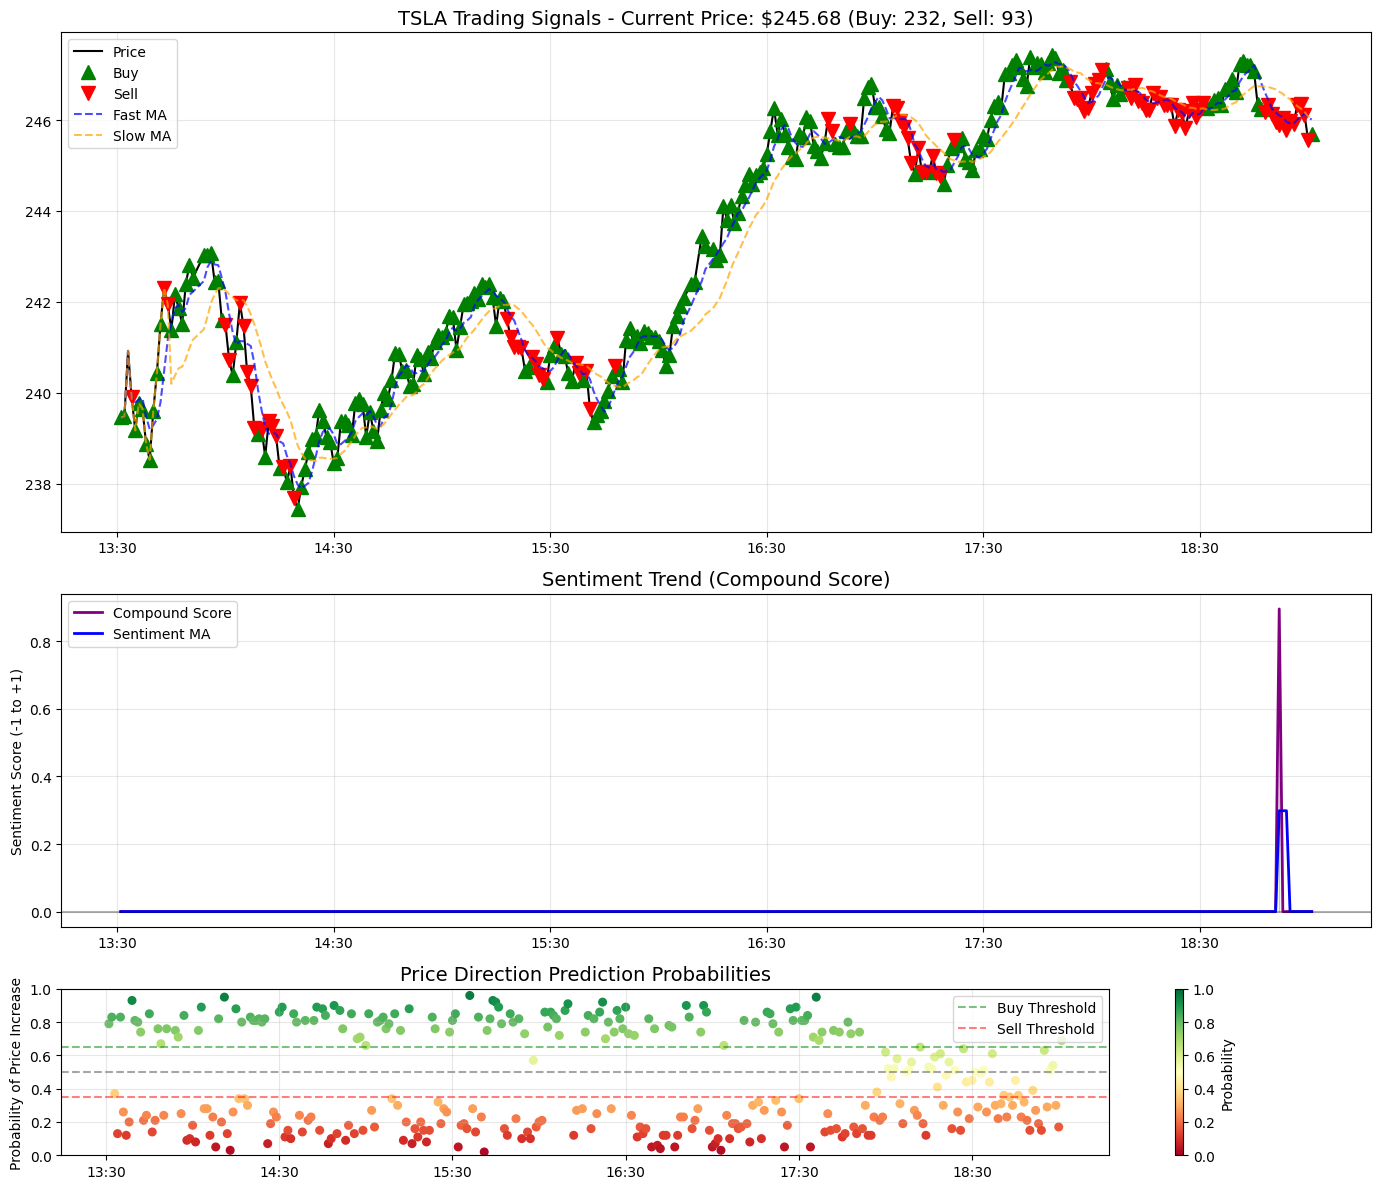

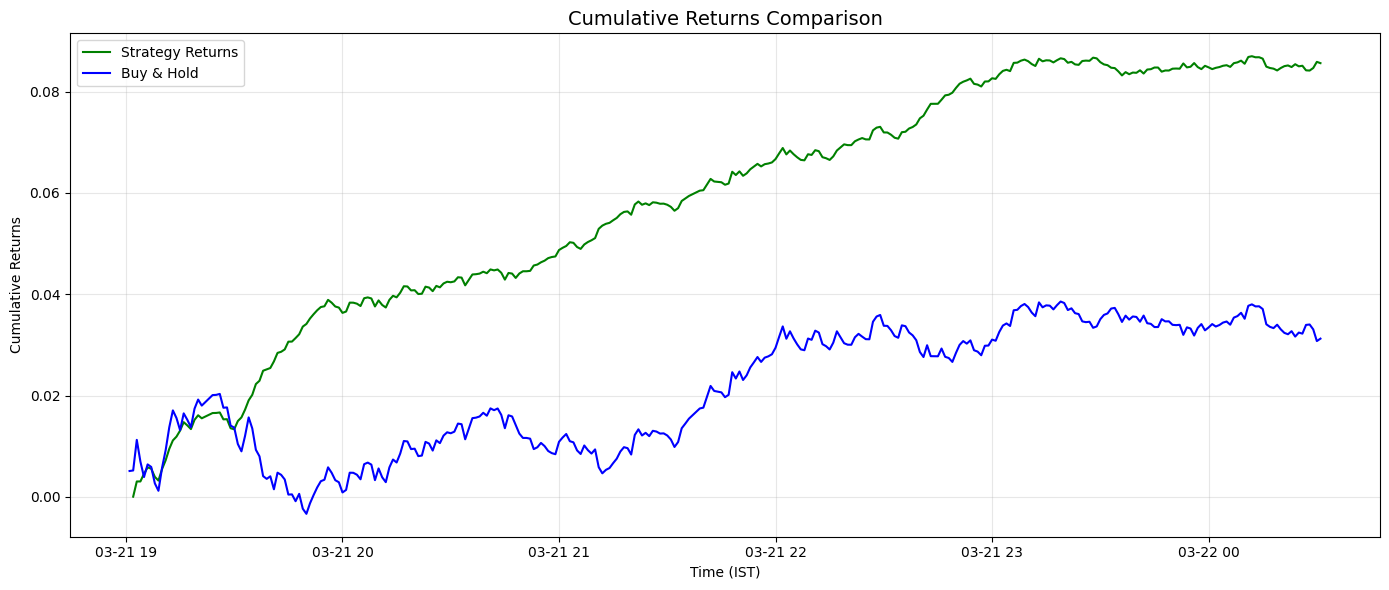


Next update in 2.0 minutes...


KeyboardInterrupt: 

In [12]:


def real_time_trading(ticker, update_interval=300, runtime=3600):

    print(f"Starting real-time trading for {ticker}...")
    print(f"Updates will occur every {update_interval/60} minutes")
    print(f"Using timezone: IST (Asia/Kolkata)")

    start_time = time.time()
    iteration = 1


    initial_price_data, initial_posts, current_price = fetch_data(ticker, period="1d", interval="1m")
    initial_sentiment = analyze_sentiment(initial_posts, ticker)


    data = process_data(initial_price_data, initial_sentiment)
    data, model = train_model(data)
    data = generate_signals(data)

    while time.time() - start_time < runtime:

        clear_output(wait=True)

        print(f"Update #{iteration} - {datetime.datetime.now(pytz.timezone('Asia/Kolkata')).strftime('%Y-%m-%d %H:%M:%S')} (IST)")


        price_data, posts, current_price = fetch_data(ticker, period="1d", interval="1m")
        sentiment_data = analyze_sentiment(posts, ticker)


        data = process_data(price_data, sentiment_data)
        data['Pred_Proba'] = model.predict_proba(data[FEATURES])[:, 1]
        data['Prediction'] = model.predict(data[FEATURES])
        data = generate_signals(data)


        latest_signal = data['Final_Signal'].iloc[-1]
        latest_probability = data['Pred_Proba'].iloc[-1]


        print("\n" + "="*50)
        print(f"CURRENT TRADING SIGNAL FOR {ticker}:")

        if latest_signal == 1:
            print(f"🟢 BUY SIGNAL 🟢")
        elif latest_signal == -1:
            print(f"🔴 SELL SIGNAL 🔴")
        else:
            print(f"⚪ HOLD/NEUTRAL ⚪")


        confidence_level = latest_probability * 100 if latest_signal == 1 else (1 - latest_probability) * 100

        print(f"\nModel Confidence: {confidence_level:.2f}%")
        print(f"Price Movement Probability: {'Upward' if latest_probability > 0.5 else 'Downward'} ({latest_probability*100:.2f}%)")


        latest_sentiment = data['Compound'].iloc[-1]
        sentiment_trend = "Positive" if latest_sentiment > 0 else "Negative" if latest_sentiment < 0 else "Neutral"

        price_trend = "Upward" if data['Price_Signal'].iloc[-1] > 0 else "Downward" if data['Price_Signal'].iloc[-1] < 0 else "Flat"

        print(f"\nInfluencing Factors:")
        print(f"• Sentiment: {sentiment_trend} ({latest_sentiment:.3f})")
        print(f"• Price Trend: {price_trend}")
        print(f"• Current Price: ${current_price:.2f}")
        print("="*50 + "\n")

        # Visualize
        visualize_strategy(data, ticker, current_price)


        elapsed = time.time() - start_time
        remaining = runtime - elapsed
        next_update = min(update_interval, remaining)

        if next_update <= 0:
            break

        print(f"\nNext update in {next_update/60:.1f} minutes...")
        time.sleep(next_update)
        iteration += 1


        if iteration % 3 == 0:
            data, model = train_model(data)

    print(f"Real-time trading session completed after {iteration} updates.")
    return data


def predict_real_time_sma(ticker, period="1y"):
    """Generates SMA crossover signals and visualization (Independent of main strategy)"""

    # Get current price
    current_data = yf.download(ticker, period="1d")
    current_price = current_data['Close'].iloc[-1] if not current_data.empty else None

    live_data = yf.download(ticker, period=period)


    live_data['SMA_50'] = live_data['Close'].rolling(window=50).mean()
    live_data['SMA_200'] = live_data['Close'].rolling(window=200).mean()


    live_data.dropna(inplace=True)
    live_data['Signal'] = np.where(live_data['SMA_50'] > live_data['SMA_200'], 1, 0)

    if live_data.empty:
        print("Not enough data to make a prediction.")
        return


    ist_time = datetime.datetime.now(pytz.timezone('Asia/Kolkata')).strftime('%Y-%m-%d %H:%M:%S')

    # Plotting
    plt.figure(figsize=(12,6))
    plt.plot(live_data['Close'], label='Closing Price', color='blue')
    plt.plot(live_data['SMA_50'], label='SMA 50', color='orange')
    plt.plot(live_data['SMA_200'], label='SMA 200', color='red')


    plt.scatter(live_data.index[live_data['Signal'] == 1],
                live_data['Close'][live_data['Signal'] == 1],
                color='green', label='Buy Signal', marker='^', alpha=1, zorder=5)
    plt.scatter(live_data.index[live_data['Signal'] == 0],
                live_data['Close'][live_data['Signal'] == 0],
                color='red', label='Sell Signal', marker='v', alpha=1, zorder=5)

    plt.legend()
    plt.title(f"{ticker} SMA Crossover Strategy - Current Price: ${current_price:.2f} (IST: {ist_time})")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid()
    plt.show()


#main
if __name__ == "__main__":

    print("Select an option:")
    print("1. Run backtest on today's data")
    print("2. Run real-time trading system")
    print("3. View long-term SMA crossover strategy")
    print("Note: All times displayed are in IST (Indian Standard Time)")

    choice = input("Enter your choice (CHOOSE 2 here) (1-3): ")
    ticker = input("Enter ticker symbol (STOCK NAME BRO eg; TSLA, AMZN, GOOGL): ")

    if choice == "1":

        price_data, posts, current_price = fetch_data(ticker)
        daily_sentiment = analyze_sentiment(posts, ticker)

        if daily_sentiment.empty:
            print("No sentiment data available")
        else:
            data = process_data(price_data, daily_sentiment)
            data, model = train_model(data)
            data = generate_signals(data)
            visualize_strategy(data, ticker, current_price)

    elif choice == "2":


        update_mins = float(input("Update interval in minutes (default: 5): ") or 5)
        runtime_hrs = float(input("Total runtime in hours (default: 1): ") or 1)


        update_interval = update_mins * 60
        runtime = runtime_hrs * 60 * 60


        real_time_trading(ticker, update_interval, runtime)

    elif choice == "3":

        period = input("Time period (default: 1y): ") or "1y"
        predict_real_time_sma(ticker, period)

    else:
        print("Invalid choice. Please run the script again.")